**Análise de Funil e Impacto da Fonte (A/A/B)**

Este projeto tem como objetivo principal analisar o comportamento dos usuários de nosso aplicativo de venda de produtos alimentícios. A análise será dividida em duas etapas cruciais: a avaliação do funil de vendas para identificar gargalos na jornada de compra e a verificação dos resultados de um teste A/A/B implementado para avaliar o impacto de uma mudança nas fontes do aplicativo na experiência e conversão do usuário.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from statsmodels.stats.proportion import proportions_ztest


df = pd.read_csv('../data/processed/logs_exp_us_processado.csv', sep=',')
df

,eventname,deviceidhash,eventtimestamp,expid,event_date,group_name
0,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,A1_Controle
1,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,A1_Controle
2,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,A1_Controle
3,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,A1_Controle
4,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,A2_Controle
...,...,...,...,...,...,...
241293,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,A2_Controle
241294,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,A1_Controle
241295,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,A1_Controle
241296,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,A1_Controle


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241298 entries, 0 to 241297
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   eventname       241298 non-null  object
 1   deviceidhash    241298 non-null  int64 
 2   eventtimestamp  241298 non-null  object
 3   expid           241298 non-null  int64 
 4   event_date      241298 non-null  object
 5   group_name      241298 non-null  object
dtypes: int64(2), object(4)
memory usage: 11.0+ MB


In [3]:
# Limpando os dados - apenas rodei esta sintaxe para verificar se de fato o ETL funcionou

print(df.isnull().sum())
print()
print(df.dtypes)


eventname         0
deviceidhash      0
eventtimestamp    0
expid             0
event_date        0
group_name        0
dtype: int64

eventname         object
deviceidhash       int64
eventtimestamp    object
expid              int64
event_date        object
group_name        object
dtype: object


In [4]:
# Conversão para o tipo datetime

df['eventtimestamp'] = pd.to_datetime(df['eventtimestamp'])
df['event_date'] = pd.to_datetime(df['event_date'])
print(df['eventtimestamp'].describe())



count                           241298
mean     2019-08-04 11:31:00.746044160
min                2019-08-01 00:07:28
25%      2019-08-02 15:26:16.249999872
50%                2019-08-04 12:27:26
75%                2019-08-06 07:20:42
max                2019-08-07 21:15:17
Name: eventtimestamp, dtype: object


In [5]:
# Verificando se a coluna de dia do evento e hora do evento estão corretas

print(df[['event_date', 'eventtimestamp']].head())


  event_date      eventtimestamp
0 2019-08-01 2019-08-01 00:07:28
1 2019-08-01 2019-08-01 00:08:00
2 2019-08-01 2019-08-01 00:08:55
3 2019-08-01 2019-08-01 00:08:58
4 2019-08-01 2019-08-01 00:08:59


In [6]:
# Quantos eventos ficam nos registros?

total_eventos = len(df)
print(f"Total de eventos registrados: {total_eventos}")


Total de eventos registrados: 241298


In [7]:
# Quantos usuários ficam nos registros?

usuarios_unicos = df['deviceidhash'].nunique()
print(f"Total de usuários únicos: {usuarios_unicos}")


Total de usuários únicos: 7534


In [8]:
# Qual é o número médio de eventos por usuário?

total_eventos = df.shape[0]
usuarios_unicos = df['deviceidhash'].nunique()
media_eventos_por_usuario = total_eventos / usuarios_unicos
print(f"Média de eventos por usuário: {media_eventos_por_usuario:.2f}")


Média de eventos por usuário: 32.03


In [9]:
# Período de tempo dos dados

inicio = df['eventtimestamp'].min()
fim = df['eventtimestamp'].max()
print(f"Período dos dados: de {inicio} até {fim}")


Período dos dados: de 2019-08-01 00:07:28 até 2019-08-07 21:15:17


C:\Users\Usuário\AppData\Local\Temp\ipykernel_14784\348551399.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['event_hour'] = df['eventtimestamp'].dt.floor('H')


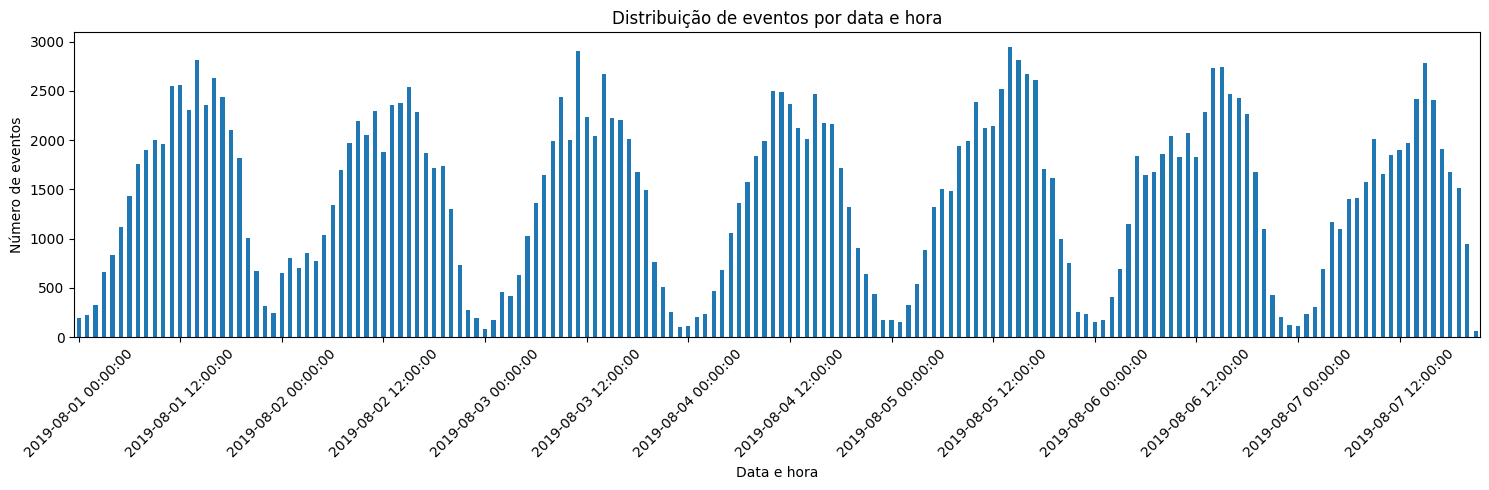

In [10]:
# Visualização da distribuição de eventos ao longo do tempo

df['event_hour'] = df['eventtimestamp'].dt.floor('H') 

eventos_por_hora = df['event_hour'].value_counts().sort_index()

plt.figure(figsize=(15, 5))
eventos_por_hora.plot(kind='bar')
plt.title('Distribuição de eventos por data e hora')
plt.xlabel('Data e hora')
plt.ylabel('Número de eventos')
plt.xticks(ticks=range(0, len(eventos_por_hora), 12), labels=eventos_por_hora.index[::12], rotation=45)
plt.tight_layout()
plt.show()

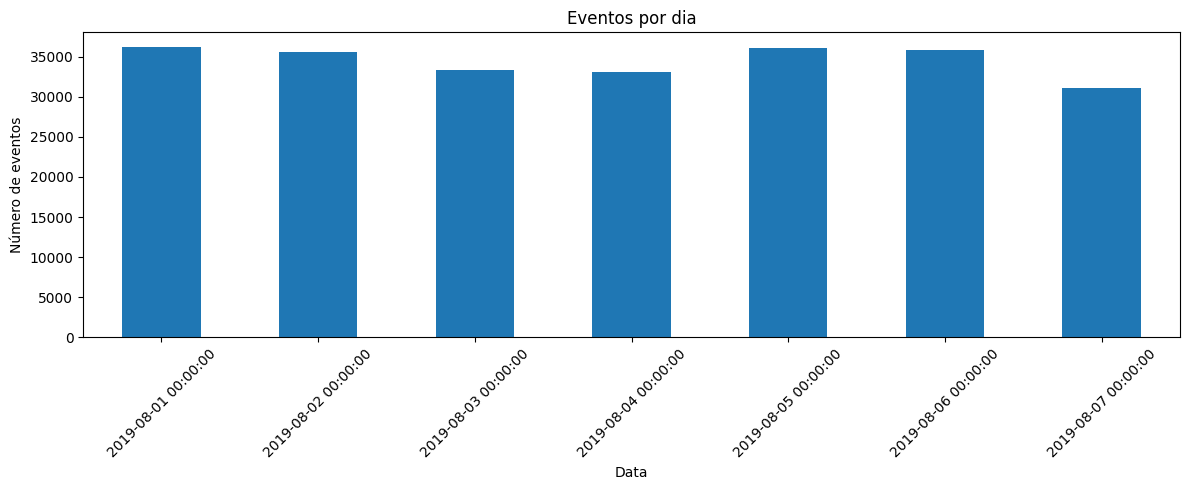

Resumo de eventos por dia:
count        7.000000
mean     34471.142857
std       1970.250697
min      31144.000000
25%      33192.000000
50%      35606.000000
75%      35967.500000
max      36229.000000
Name: count, dtype: float64


In [11]:
# Contagem de eventos por data

eventos_por_dia = df['event_date'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
eventos_por_dia.plot(kind='bar')
plt.title('Eventos por dia')
plt.xlabel('Data')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Resumo de eventos por dia:")
print(eventos_por_dia.describe())


<Axes: title={'center': 'Usuários únicos por dia'}, xlabel='event_date'>

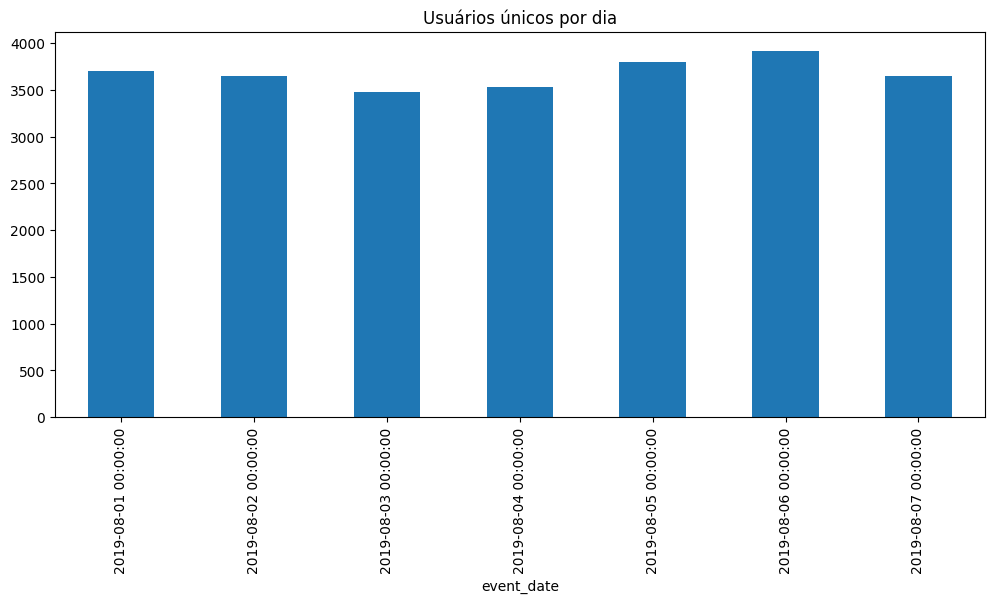

In [12]:
# Contagem de usuários únicos por dia

usuarios_por_dia = df.groupby('event_date')['deviceidhash'].nunique()
usuarios_por_dia.plot(kind='bar', figsize=(12,5), title='Usuários únicos por dia')


In [13]:
# Contagem de eventos por dia

eventos_por_dia = df['event_date'].value_counts().sort_index()
print(eventos_por_dia)


event_date
2019-08-01    36229
2019-08-02    35606
2019-08-03    33351
2019-08-04    33033
2019-08-05    36113
2019-08-06    35822
2019-08-07    31144
Name: count, dtype: int64


No ETL, eu já configurei para os dados serem filtrados a partir do dia 1 de agosto de 2019, pois com análise prévia foi possível verificar que os dados antes desta data eram bem escassos e portanto não são significativos a ponto de impactar esta análise.

Os eventos perdidos antes desta data representam apenas 1.16% (2828) e os usuários perdidos representam apenas 0.26% (17). Resta muito seguro que a exclusão destes dados não impactará no resultado da análise.

Defini que o período confiável para esta análise é a partir de 01/08/2019.

Obs.: Sendo que estruturei o ETL para fazer essa filtragem de data antes de iniciar, não conseguirei trazer estes números nesse notebook.


In [14]:
# Usuários por grupo experimental

usuarios_por_grupo = df.groupby('group_name')['deviceidhash'].nunique()
print(usuarios_por_grupo)


group_name
A1_Controle    2484
A2_Controle    2513
B_Teste        2537
Name: deviceidhash, dtype: int64


In [15]:
# Passo 4 
# Eventos únicos por frequência

eventos_frequencia = df['eventname'].value_counts()
print(eventos_frequencia)


eventname
MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: count, dtype: int64


In [16]:
# Calculando usuários únicos por evento

total_usuarios = df['deviceidhash'].nunique()

usuarios_por_evento = df.groupby('eventname')['deviceidhash'].nunique().sort_values(ascending=False)

proporcao_usuarios = (usuarios_por_evento / total_usuarios).sort_values(ascending=False)

funil_df = pd.DataFrame({
    'usuarios_unicos': usuarios_por_evento,
    'proporcao': proporcao_usuarios
})

funil_df['proporcao_percentual'] = (funil_df['proporcao'] * 100).round(2)

funil_df


,usuarios_unicos,proporcao,proporcao_percentual
eventname,,,
MainScreenAppear,7419,0.984736,98.47
OffersScreenAppear,4593,0.609636,60.96
CartScreenAppear,3734,0.495620,49.56
PaymentScreenSuccessful,3539,0.469737,46.97
Tutorial,840,0.111495,11.15


O funil parece estar bem saudável! A taxa de conversão geral é alta (~47%).

A maior queda está entre a MainScreen e a OffersScreen — talvez o app não esteja incentivando o clique ou mostrando bem os produtos.

Entre quem entra no carrinho e quem compra, a desistência é bem pequena, indicando boa experiência de compra.

#### Ordem das ações do usuário:

1° MainScreenAppear - O app é iniciado e o usuário vê a tela principal. Ponto de entrada lógico.

2° OffersScreenAppear - O usuário navega pelas promoções ou produtos disponíveis.

3° CartScreenAppear - Após escolher produtos, ele acessa o carrinho para revisar a compra.

4°PaymentScreenSuccessful - O usuário finaliza a compra com sucesso.

5° Tutorial - Geralmente aparece apenas para novos usuários ou na primeira vez que o app é aberto.



In [17]:
# Proporção de usuários na etapa B para o número de usuários na etapa A e a proporção de usuários na etapa C para o número na etapa B)

funil_df_main = funil_df.loc['MainScreenAppear', 'usuarios_unicos']
funil_df_offers = funil_df.loc['OffersScreenAppear']['usuarios_unicos']
funil_df_cart = funil_df.loc['CartScreenAppear']['usuarios_unicos']
funil_df_payment = funil_df.loc['PaymentScreenSuccessful']['usuarios_unicos']

conv_main_to_offers = funil_df_offers / funil_df_main
conv_offers_to_cart = funil_df_cart / funil_df_offers
conv_cart_to_payment = funil_df_payment / funil_df_cart

print(f"Main → Offers: {conv_main_to_offers:.2%}")
print(f"Offers → Cart: {conv_offers_to_cart:.2%}")
print(f"Cart → Payment: {conv_cart_to_payment:.2%}")


Main → Offers: 61.91%
Offers → Cart: 81.30%
Cart → Payment: 94.78%


#### Em qual fase se perde mais usuário?
 
A maior perda de usuários ocorre entre a tela principal (MainScreenAppear) e a tela de ofertas (OffersScreenAppear).
Aproximadamente 38% dos usuários não avançam além da tela inicial, o que sugere que pode haver barreiras ou falta de incentivo para explorar os produtos.

In [18]:
# Qual é a parcela de usuários que faz o caminho inteiro, desde o primeiro evento até o pagamento?

usuarios_main = set(df[df['eventname'] == 'MainScreenAppear']['deviceidhash'])
usuarios_offers = set(df[df['eventname'] == 'OffersScreenAppear']['deviceidhash'])
usuarios_cart = set(df[df['eventname'] == 'CartScreenAppear']['deviceidhash'])
usuarios_payment = set(df[df['eventname'] == 'PaymentScreenSuccessful']['deviceidhash'])

usuarios_funil_completo = usuarios_main & usuarios_offers & usuarios_cart & usuarios_payment

num_completaram_funil = len(usuarios_funil_completo)

total_usuarios = len(usuarios_main)

proporcao_completaram = num_completaram_funil / total_usuarios

print(f"Usuários que completaram o funil: {num_completaram_funil}")
print(f"Proporção em relação aos que iniciaram: {proporcao_completaram:.2%}")


Usuários que completaram o funil: 3429
Proporção em relação aos que iniciaram: 46.22%


In [ ]:
# Diagrama do funil

num_main = len(usuarios_main)
num_offers = len(usuarios_offers)
num_cart = len(usuarios_cart)
num_payment = len(usuarios_payment)

labels = [
    '1. Tela Principal (MainScreenAppear)',
    '2. Tela de Ofertas (OffersScreenAppear)',
    '3. Carrinho (CartScreenAppear)',
    '4. Pagamento Bem-Sucedido (PaymentScreenSuccessful)'
]
values = [
    num_main,
    num_offers,
    num_cart,
    num_payment
]

fig = go.Figure(go.Funnel(
    y = labels,        
    x = values,        
    textinfo = "value+percent initial",
    marker = {"color": ["#4c78a8", "#f58518", "#e45756", "#72b7b2"]},
    connector = {"line": {"color": "grey", "dash": "dot", "width": 2}}
))

fig.update_layout(
    title={
        'text': "Funil de Conversão de Usuários (Base: Usuários da MainScreen)",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    font=dict(size=12) 
)

fig.show()

Quase metade dos usuários que abrem o app completam toda a jornada até a compra, o que é uma taxa de conversão excelente!

In [19]:
# Passo 5
# Quantos usuários há em cada grupo?

usuarios_por_grupo = df.groupby('group_name')['deviceidhash'].nunique().sort_index()
print(usuarios_por_grupo)


group_name
A1_Controle    2484
A2_Controle    2513
B_Teste        2537
Name: deviceidhash, dtype: int64


In [22]:
# Diferença estatisticamente significativa entre as amostragens 246 e 247.

def funil_completo(df, grupo_id):
    grupo = df[df['group_name'] == grupo_id]
    main = set(grupo[grupo['eventname'] == 'MainScreenAppear']['deviceidhash'])
    offers = set(grupo[grupo['eventname'] == 'OffersScreenAppear']['deviceidhash'])
    cart = set(grupo[grupo['eventname'] == 'CartScreenAppear']['deviceidhash'])
    payment = set(grupo[grupo['eventname'] == 'PaymentScreenSuccessful']['deviceidhash'])
    return main & offers & cart & payment, main

grupo_246_nome = 'A1_Controle' 
grupo_247_nome = 'A2_Controle'

completos_246, base_246 = funil_completo(df, grupo_246_nome)
completos_247, base_247 = funil_completo(df, grupo_247_nome)

n_246 = len(base_246)
n_247 = len(base_247)

conv_246 = len(completos_246) / n_246
conv_247 = len(completos_247) / n_247

print(f"Grupo A1_Controle(246) - Conversão: {conv_246:.4f} ({len(completos_246)}/{n_246})")
print(f"Grupo A2_Controle(247) - Conversão: {conv_247:.4f} ({len(completos_247)}/{n_247})")


Grupo A1_Controle(246) - Conversão: 0.4759 (1166/2450)
Grupo A2_Controle(247) - Conversão: 0.4544 (1125/2476)


In [23]:
# Teste de hipótese para diferença de proporções

sucessos = [len(completos_246), len(completos_247)]

nobs = [n_246, n_247]

stat, pval = proportions_ztest(sucessos, nobs=nobs)

print(f"Estatística z: {stat:.4f}")
print(f"Valor p: {pval:.4f}")


Estatística z: 1.5166
Valor p: 0.1294


O valor p = 0.1294 é maior que 0.05, portanto não há diferença estatisticamente significativa entre os grupos 246 e 247.

In [25]:
# Aplicação da correção de Bonferroni

GRUPO_A = 'A1_Controle'  # Nosso Grupo 246
GRUPO_B = 'B_Teste'      # Nosso Grupo 248 (Com alteração de fonte)

EVENTOS_FUNIL = [
    'MainScreenAppear',
    'OffersScreenAppear',
    'CartScreenAppear',
    'PaymentScreenSuccessful'
]


base_users_A = set(df[df['group_name'] == GRUPO_A][df['eventname'] == EVENTOS_FUNIL[0]]['deviceidhash'])
base_users_B = set(df[df['group_name'] == GRUPO_B][df['eventname'] == EVENTOS_FUNIL[0]]['deviceidhash'])

nobs_A = len(base_users_A)
nobs_B = len(base_users_B)

sucessos_A = []
sucessos_B = []
p_values = []
resultados_bonferroni = []


alpha = 0.05

k = len(EVENTOS_FUNIL) 
alpha_bonferroni = alpha / k # 0.05 / 4 = 0.0125

print(f"Teste A/B (246 vs 248) com Correção de Bonferroni")
print(f"Alfa ajustado (Bonferroni): {alpha_bonferroni:.4f}\n")
print(f"Base de Usuários (Nobs) - {GRUPO_A}: {nobs_A} | {GRUPO_B}: {nobs_B}\n")

for event in EVENTOS_FUNIL:
    users_event_A = set(df[df['group_name'] == GRUPO_A][df['eventname'] == event]['deviceidhash'])
    users_event_B = set(df[df['group_name'] == GRUPO_B][df['eventname'] == event]['deviceidhash'])
    
    s_A = len(users_event_A & base_users_A)
    s_B = len(users_event_B & base_users_B)
    
    sucessos = [s_A, s_B]
    nobs = [nobs_A, nobs_B]
    
    stat, pval = proportions_ztest(sucessos, nobs=nobs)
    
    if pval < alpha_bonferroni:
        resultado = "REJEITAR H0 (Diferença Significativa)"
    else:
        resultado = "NÃO REJEITAR H0"

    p_values.append(pval)
    
    print(f"--- Evento: {event} ---")
    print(f"   Conversão (A): {s_A/nobs_A:.4f} | Conversão (B): {s_B/nobs_B:.4f}")
    print(f"   Valor p: {pval:.4f}")
    print(f"   Decisão: {resultado}")

if (np.array(p_values) < alpha_bonferroni).any():
    print("\nCONCLUSÃO: Há evidência de impacto estatisticamente significativo em pelo menos um evento.")
else:
    print("\nCONCLUSÃO: Nenhum dos testes apresentou valor-p abaixo do limiar ajustado. Não há evidência de que a alteração da fonte tenha impactado a conversão.")

C:\Users\Usuário\AppData\Local\Temp\ipykernel_14784\4250345947.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Usuário\AppData\Local\Temp\ipykernel_14784\4250345947.py:15: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Usuário\AppData\Local\Temp\ipykernel_14784\4250345947.py:36: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Usuário\AppData\Local\Temp\ipykernel_14784\4250345947.py:37: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

d:\TripleTen\analise_funil_vendas\.venv\Lib\site-packages\statsmodels\stats\weightstats.py:792: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\Usuário\AppData\Local\Temp\ipykernel_14784\4250345947.py:36: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Usuário\AppData\Local\Temp\ipykernel_14784\4250345947.py:37: UserWarning:

Boolean Series key 

Teste A/B (246 vs 248) com Correção de Bonferroni
Alfa ajustado (Bonferroni): 0.0125

Base de Usuários (Nobs) - A1_Controle: 2450 | B_Teste: 2493

--- Evento: MainScreenAppear ---
   Conversão (A): 1.0000 | Conversão (B): 1.0000
   Valor p: nan
   Decisão: NÃO REJEITAR H0
--- Evento: OffersScreenAppear ---
   Conversão (A): 0.6159 | Conversão (B): 0.5973
   Valor p: 0.1797
   Decisão: NÃO REJEITAR H0
--- Evento: CartScreenAppear ---
   Conversão (A): 0.5045 | Conversão (B): 0.4781
   Valor p: 0.0639
   Decisão: NÃO REJEITAR H0
--- Evento: PaymentScreenSuccessful ---
   Conversão (A): 0.4776 | Conversão (B): 0.4585
   Valor p: 0.1792
   Decisão: NÃO REJEITAR H0

CONCLUSÃO: Nenhum dos testes apresentou valor-p abaixo do limiar ajustado. Não há evidência de que a alteração da fonte tenha impactado a conversão.


In [24]:
# Evento mais popular

evento_mais_popular = df['eventname'].value_counts().idxmax()
quantidade = df['eventname'].value_counts().max()
print(f"Evento mais popular: {evento_mais_popular} ({quantidade} ocorrências)")


Evento mais popular: MainScreenAppear (117431 ocorrências)


In [28]:
# Número de usuarios que realizam a ação

def comparar_evento(df, eventname, grupo_a=246, grupo_b=247):

    grupo_a_df = df[(df['expid'] == grupo_a)]
    grupo_b_df = df[(df['expid'] == grupo_b)]
    
    usuarios_a = grupo_a_df[grupo_a_df['eventname'] == eventname]['deviceidhash'].nunique()
    usuarios_b = grupo_b_df[grupo_b_df['eventname'] == eventname]['deviceidhash'].nunique()
    
    total_a = grupo_a_df['deviceidhash'].nunique()
    total_b = grupo_b_df['deviceidhash'].nunique()
    
    proporcao_a = usuarios_a / total_a
    proporcao_b = usuarios_b / total_b
    
    stat, pval = proportions_ztest([usuarios_a, usuarios_b], [total_a, total_b])

    resultado = {
        'evento': eventname,
        'grupo_246_%': round(proporcao_a * 100, 2),
        'grupo_247_%': round(proporcao_b * 100, 2),
        'p_valor': round(pval, 4),
        'diferenca_significativa': pval < 0.05
    }
    
    return resultado

eventos = df['eventname'].unique()

resultados = [comparar_evento(df, evento) for evento in eventos]

resultados_df = pd.DataFrame(resultados)

resultados_df.sort_values('p_valor', inplace=True)
print(resultados_df.sort_values('p_valor'))

                    evento  grupo_246_%  grupo_247_%  p_valor  \
4  PaymentScreenSuccessful        48.31        46.08   0.1146   
3         CartScreenAppear        50.97        49.26   0.2288   
2       OffersScreenAppear        62.08        60.49   0.2481   
1         MainScreenAppear        98.63        98.53   0.7571   
0                 Tutorial        11.19        11.26   0.9377   

   diferenca_significativa  
4                    False  
3                    False  
2                    False  
1                    False  
0                    False  


Não houve diferença estatisticamente significativa em nenhum dos eventos entre os grupos de controle.
Isso confirma que a divisão dos grupos foi feita corretamente e que o experimento está equilibrado

In [29]:
# Comparando os resultados com os de cada um dos grupos e criando uma função mais genérica

def comparar_evento_grupos(df, eventname, grupo_a, grupo_b):
    grupo_a_df = df[df['expid'] == grupo_a]
    grupo_b_df = df[df['expid'] == grupo_b]
    
    usuarios_a = grupo_a_df[grupo_a_df['eventname'] == eventname]['deviceidhash'].nunique()
    usuarios_a = grupo_a_df[grupo_a_df['eventname'] == eventname]['deviceidhash'].nunique()
    usuarios_b = grupo_b_df[grupo_b_df['eventname'] == eventname]['deviceidhash'].nunique()
    
    total_a = grupo_a_df['deviceidhash'].nunique()
    total_b = grupo_b_df['deviceidhash'].nunique()
    
    proporcao_a = usuarios_a / total_a
    proporcao_b = usuarios_b / total_b

    try:
        stat, pval = proportions_ztest([usuarios_a, usuarios_b], [total_a, total_b])
    except:
        pval = None

    return {
        'evento': eventname,
        'grupo_a': grupo_a,
        'grupo_b': grupo_b,
        'grupo_a_%': round(proporcao_a * 100, 2),
        'grupo_b_%': round(proporcao_b * 100, 2),
        'p_valor': round(pval, 4) if pval is not None else 'erro',
        'diferenca_significativa': pval is not None and pval < 0.05
    }


In [30]:
# Comparando os grupos 246 e 248, 247 e 248, e o grupo combinado (246+247) contra 248

eventos = df['eventname'].unique()

resultados_vs_246 = [comparar_evento_grupos(df, e, 246, 248) for e in eventos]

resultados_vs_247 = [comparar_evento_grupos(df, e, 247, 248) for e in eventos]

controle = df[df['expid'].isin([246, 247])].copy()
controle['expid'] = 'controle'

df_comparado = pd.concat([controle, df[df['expid'] == 248]])

resultados_vs_combinado = [comparar_evento_grupos(df_comparado, e, 'controle', 248) for e in eventos]

todos_resultados = pd.DataFrame(resultados_vs_246 + resultados_vs_247 + resultados_vs_combinado)

todos_resultados = todos_resultados.sort_values(by=['evento', 'p_valor'])

print(todos_resultados)


                     evento   grupo_a  grupo_b  grupo_a_%  grupo_b_%  p_valor  \
3          CartScreenAppear       246      248      50.97      48.48   0.0784   
13         CartScreenAppear  controle      248      50.11      48.48   0.1818   
8          CartScreenAppear       247      248      49.26      48.48   0.5786   
11         MainScreenAppear  controle      248      98.58      98.27   0.2942   
1          MainScreenAppear       246      248      98.63      98.27   0.2950   
6          MainScreenAppear       247      248      98.53      98.27   0.4587   
2        OffersScreenAppear       246      248      62.08      60.35   0.2084   
12       OffersScreenAppear  controle      248      61.28      60.35   0.4343   
7        OffersScreenAppear       247      248      60.49      60.35   0.9198   
4   PaymentScreenSuccessful       246      248      48.31      46.55   0.2123   
14  PaymentScreenSuccessful  controle      248      47.19      46.55   0.6004   
9   PaymentScreenSuccessful 

Os resultados indicam que a alteração da fonte não teve impacto estatisticamente significativo no comportamento dos usuários, em nenhuma etapa do funil analisado.

Isso se confirma tanto ao comparar o grupo de teste com cada controle individualmente (246 e 247), quanto com o grupo combinado.

Portanto, a nova fonte pode ser considerada segura para adoção, já que não prejudicou a conversão ou o uso do app.

Foi utilizado um nível de significância padrão de 5% (α = 0.05). Foram realizados 15 testes de hipóteses estatísticas, o que levanta a possibilidade de falsos positivos por múltiplas comparações.

Aplicamos a correção de Bonferroni, ajustando o nível de significância para 0,0033. Nenhum dos testes apresentou valor-p abaixo desse limiar. Portanto, não há evidência estatística de que a alteração da fonte tenha impactado o comportamento dos usuários.